In [9]:
# === Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import ta  

# Load price data
price_path = "C:/Users/TadeleBizuye/GOOG_historical_data.csv"
price_df = pd.read_csv(price_path, parse_dates=['Date'])
daily_df = price_df.groupby('Date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

# Load sentiment data
sentiment_path = "C:/Users/TadeleBizuye/raw_analyst_ratings.csv"
sentiment_df = pd.read_csv(sentiment_path, parse_dates=['date'])
sentiment_df = sentiment_df[sentiment_df['stock'] == 'GOOG']

# Sentiment score
from textblob import TextBlob
sentiment_df['sentiment_score'] = sentiment_df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Aggregate daily sentiment
daily_sentiment = sentiment_df.groupby('date').agg({'sentiment_score': 'mean'}).reset_index().rename(columns={'date':'Date'})

# Convert dates to datetime and merge
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], errors='coerce')
daily_sentiment = daily_sentiment.dropna(subset=['Date'])

merged_df = pd.merge(daily_df, daily_sentiment, on='Date', how='left')
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)


### Next Step Visualozation

C:\Users\TadeleBizuye\AppData\Local\Temp\ipykernel_25040\555774942.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Close'] = merged_df['Close'].fillna(method='ffill')


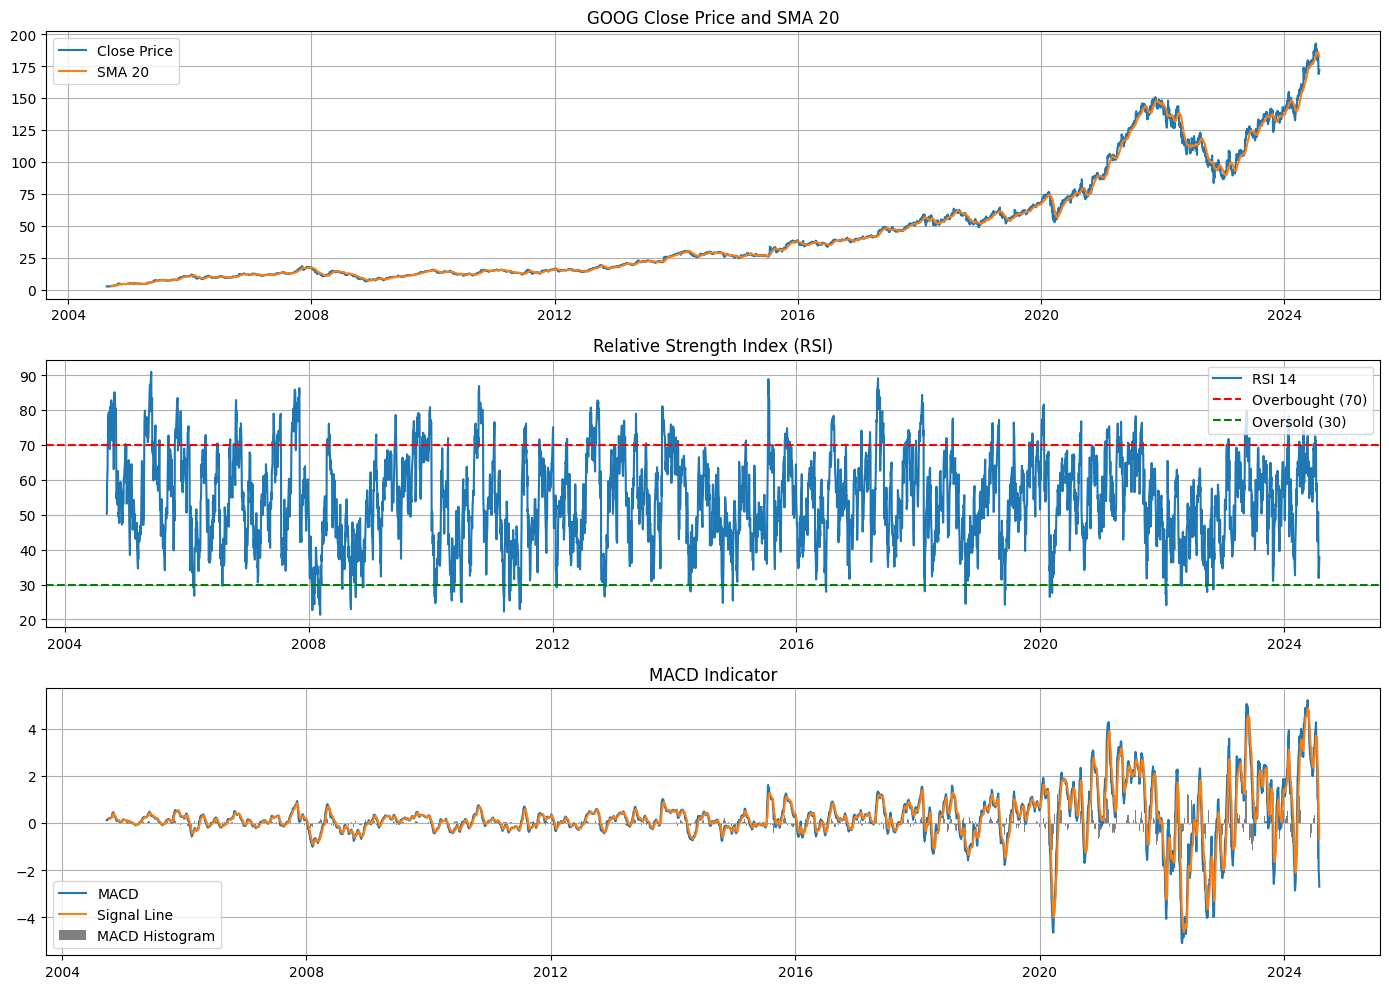

In [10]:
# For safety, fill missing Close prices if any (forward fill)
merged_df['Close'] = merged_df['Close'].fillna(method='ffill')

# === Step 1: Calculate Technical Indicators using ta library ===

# Simple Moving Average (SMA) - 20 days
merged_df['SMA_20'] = ta.trend.sma_indicator(merged_df['Close'], window=20)

# Relative Strength Index (RSI) - 14 days
merged_df['RSI_14'] = ta.momentum.rsi(merged_df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(merged_df['Close'])
merged_df['MACD'] = macd.macd()
merged_df['MACD_signal'] = macd.macd_signal()
merged_df['MACD_diff'] = macd.macd_diff()

# === Step 2: Visualize the Results ===

plt.figure(figsize=(14, 10))

# Plot Close Price and SMA 20
plt.subplot(3, 1, 1)
plt.plot(merged_df['Date'], merged_df['Close'], label='Close Price')
plt.plot(merged_df['Date'], merged_df['SMA_20'], label='SMA 20')
plt.title('GOOG Close Price and SMA 20')
plt.legend()
plt.grid()

# Plot RSI with thresholds
plt.subplot(3, 1, 2)
plt.plot(merged_df['Date'], merged_df['RSI_14'], label='RSI 14')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.grid()

# Plot MACD and Signal line
plt.subplot(3, 1, 3)
plt.plot(merged_df['Date'], merged_df['MACD'], label='MACD')
plt.plot(merged_df['Date'], merged_df['MACD_signal'], label='Signal Line')
plt.bar(merged_df['Date'], merged_df['MACD_diff'], label='MACD Histogram', color='grey')
plt.title('MACD Indicator')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
